# Layered Embeddings

## Initialise

In [1]:
!pip install graphdatascience python-dotenv umap-learn scikit-learn==1.4.2 matplotlib seaborn


[notice] A new release of pip is available: 23.2.1 -> 24.2
[notice] To update, run: pip install --upgrade pip


In [2]:
import pandas as pd
import numpy as np
from graphdatascience import GraphDataScience, Graph

def drop_graph_if_exists(gds: GraphDataScience,
                         projections: list):
  """Drop named GDS projections in list.

  Args:
    gds : GraphDataScience
      Neo4j GDS session object
    projections: list
      List of projection names
  """
  # Check for existence of each named projection
  filtered_projections = list(filter(lambda x: x in projections, gds.graph.list()['graphName']))
  # Drop projections
  _ = list(map(lambda x: gds.graph.drop(gds.graph.get(x)), filtered_projections))


def reduce_embedding(df: pd.DataFrame, algorithm, property_column='propertyValue', reduce_column='reduced'):
  # Apply dimensionality reduction algorithm to embedding
  transformed = algorithm.fit_transform(np.array(list(df[property_column])))

  # Concatenate reduced transformation into Dataframe
  dfX = pd.concat([df, pd.Series(list(transformed))], axis=1, ignore_index=True, join='outer')

  # Name columns following concatenation
  dfX = dfX.set_axis(list(df.columns) + [reduce_column], axis=1)
  return dfX


def cluster_embedding(df: pd.DataFrame, algorithm, property_column='propertyValue', cluster_column='cluster'):
  # Apply clustering algorithm to embedding
  algorithm.fit(np.array(list(df[property_column])))

  # Concatenate cluster labels into Dataframe
  dfX = pd.concat([df, pd.DataFrame(list(algorithm.labels_))], axis=1, ignore_index=True, join='outer')

  # Name columns following concatenation
  dfX = dfX.set_axis(list(df.columns) + [cluster_column], axis=1)
  return dfX

In [3]:
from sklearn.cluster import HDBSCAN
import umap.umap_ as umap
import time

from dotenv import load_dotenv
import os
import random
import pandas as pd
pd.set_option('display.max_rows', 100)
load_dotenv()

NEO4J_URI = os.environ.get("NEO4J_URI", "bolt://localhost:7687")
NEO4J_AUTH = None
NEO4J_DB = os.environ.get("NEO4J_DB", "neo4j")
if os.environ.get("NEO4J_USER") and os.environ.get("NEO4J_PASSWORD"):
    NEO4J_AUTH = (
        os.environ.get("NEO4J_USER"),
        os.environ.get("NEO4J_PASSWORD"),
    )

from neo4j import GraphDatabase
driver = GraphDatabase.driver(NEO4J_URI, auth=NEO4J_AUTH)
n4j = driver.session(database=NEO4J_DB)


gds = GraphDataScience(NEO4J_URI, auth=NEO4J_AUTH, database=NEO4J_DB)

In [4]:
import numpy

SEED = 123
numpy.random.seed(SEED)
random.seed(SEED)

## Create Graph

In [5]:
nA = 10000
nB = 10000
nZ = 7
connections = 4

n4j.run('MATCH (n) DETACH DELETE n')

n4j.run("CREATE CONSTRAINT a_name IF NOT EXISTS FOR (n:A) REQUIRE (n.name) IS UNIQUE")
n4j.run("CREATE CONSTRAINT b_name IF NOT EXISTS FOR (n:B) REQUIRE (n.name) IS UNIQUE")
n4j.run("CREATE CONSTRAINT z_name IF NOT EXISTS FOR (n:Z) REQUIRE (n.name) IS UNIQUE")

n4j.run("UNWIND $records AS row MERGE (:A {name: row})", records=list(range(nA)))
n4j.run("UNWIND $records AS row MERGE (:B {name: row})", records=list(range(nB)))
n4j.run("UNWIND $records AS row MERGE (:Z {name: row})", records=list(range(nZ)))

n4j.run("UNWIND $records AS row MATCH (a:A {name: row}) MATCH (b:B {name: row}) MERGE (a)-[:FOLLOW]->(b)", records=list(range(nA)))

# Generate random traits
traits = list(map(lambda x: [x, random.sample(range(nZ), connections)], range(nA)))

n4j.run("UNWIND $records AS row MATCH (b:B {name: row[0]}) UNWIND row[1] AS x MATCH (z:Z {name: x}) MERGE (b)-[:TRAIT]->(z)", records=traits)
time.sleep(2)

## Approach A - Direct

### Project

In [6]:
PROJECTION1 = 'ABZ'
list(map(lambda x: gds.graph.drop(gds.graph.get(x)), list(filter(lambda x: x in [PROJECTION1], gds.graph.list()['graphName']))))
cypher = """
CALL {
    MATCH (a:A)-[r1:FOLLOW]->(b:B)
    RETURN a AS source, labels(a) AS sourceLabel, b AS target, labels(b) AS targetLabel, type(r1) AS relType
    UNION ALL
    MATCH (a:A)-[r1:FOLLOW]->(b:B)-[r2:TRAIT]->(z:Z)
    RETURN b AS source, labels(b) AS sourceLabel, z AS target, labels(z) AS targetLabel, type(r2) AS relType
}
RETURN gds.graph.project($projection_name, source, target,
  {sourceNodeLabels: sourceLabel,
  targetNodeLabels: targetLabel,
  relationshipType: relType},
  {undirectedRelationshipTypes: ['*']})
"""

G, result = gds.graph.cypher.project(cypher, projection_name=PROJECTION1)
result
gds.graph.list()

,degreeDistribution,graphName,database,databaseLocation,memoryUsage,sizeInBytes,nodeCount,relationshipCount,configuration,density,creationTime,modificationTime,schema,schemaWithOrientation
0,"{'min': 1, 'max': 5784, 'p90': 5, 'p999': 5, '...",ABZ,neo4j,local,8831 KiB,9043694,20007,100000,"{'readConcurrency': 4, 'undirectedRelationship...",0.00025,2024-09-06T10:25:39.347778000+00:00,2024-09-06T10:25:39.412915000+00:00,"{'graphProperties': {}, 'nodes': {'A': {}, 'B'...","{'graphProperties': {}, 'nodes': {'A': {}, 'B'..."


### Embed

In [7]:
EMBEDDING1 = 'fastRP1'
EMBEDDING_DIMENSION = 128
RANDOM_SEED = 42
GA = gds.graph.get(PROJECTION1)
gds.fastRP.mutate(GA, iterationWeights=[1.0], embeddingDimension=EMBEDDING_DIMENSION, mutateProperty=EMBEDDING1, randomSeed=RANDOM_SEED, nodeLabels=['B', 'Z'], concurrency=1)
dfBe = gds.graph.nodeProperty.stream(GA, EMBEDDING1, 'B')
dfBe.head()

,nodeId,propertyValue
0,10000,"[0.07198158, -0.07198158, 0.0, -0.14396316, -0..."
1,10001,"[0.13703774, -0.06851887, 0.0, -0.13703774, -0..."
2,10002,"[0.145865, -0.0729325, 0.0, -0.0729325, -0.072..."
3,10003,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.16064386, -0.08032..."
4,10004,"[0.07738232, 0.0, 0.0, 0.0, 0.0, 0.15476464, -..."


### Cluster, reduce, cluster

In [8]:
%%time
dfBc = cluster_embedding(dfBe, HDBSCAN(min_samples=20, min_cluster_size=10, n_jobs=-1), cluster_column='raw')
print("1")
print(dfBc)
dfBc = reduce_embedding(dfBc, umap.UMAP(n_neighbors=30, min_dist=0.1, n_components=2))
print("2")
print(dfBc)
dfBc = cluster_embedding(dfBc, HDBSCAN(min_samples=20, min_cluster_size=10, n_jobs=-1), property_column='reduced', cluster_column='umap')
print("3")
print(dfBc)

1
      nodeId                                      propertyValue  raw
0      10000  [0.07198158, -0.07198158, 0.0, -0.14396316, -0...   32
1      10001  [0.13703774, -0.06851887, 0.0, -0.13703774, -0...   33
2      10002  [0.145865, -0.0729325, 0.0, -0.0729325, -0.072...   28
3      10003  [0.0, 0.0, 0.0, 0.0, 0.0, 0.16064386, -0.08032...    7
4      10004  [0.07738232, 0.0, 0.0, 0.0, 0.0, 0.15476464, -...   17
...      ...                                                ...  ...
9995   19995  [0.14359163, 0.0, 0.0, -0.071795814, -0.143591...   31
9996   19996  [0.14784425, 0.0, 0.0, 0.0, -0.07392213, 0.147...   25
9997   19997  [0.07881104, 0.07881104, 0.0, 0.0, -0.15762208...    6
9998   19998  [0.14285713, -0.14285713, 0.0, -0.14285713, -0...   30
9999   19999  [0.0, 0.0778499, 0.0, 0.0, -0.0778499, 0.0, -0...   10

[10000 rows x 3 columns]
2
      nodeId                                      propertyValue  raw  \
0      10000  [0.07198158, -0.07198158, 0.0, -0.14396316, -0...   32  

### Raw Clusters

In [9]:
dfBc['raw'].value_counts()

raw
19    318
13    317
32    312
10    306
15    302
3     301
31    298
17    297
28    296
27    295
12    293
18    293
11    292
22    289
1     286
7     286
21    285
24    284
25    283
20    282
9     282
29    281
6     280
33    280
0     279
5     277
2     275
26    274
23    271
30    271
34    270
14    268
16    264
4     264
8     249
Name: count, dtype: int64

### UMAP Clusters

In [10]:
dfBc['umap'].value_counts()

umap
28    318
33    317
15    312
5     306
14    302
30    301
12    298
25    297
2     296
10    295
19    293
16    293
0     292
9     289
31    286
27    286
7     285
21    284
13    283
17    282
34    282
22    281
24    280
20    280
23    279
18    277
32    275
8     274
6     271
4     271
11    270
3     268
1     264
29    264
26    249
Name: count, dtype: int64

### UMAP Cluster Plot

<Axes: xlabel='x', ylabel='y'>

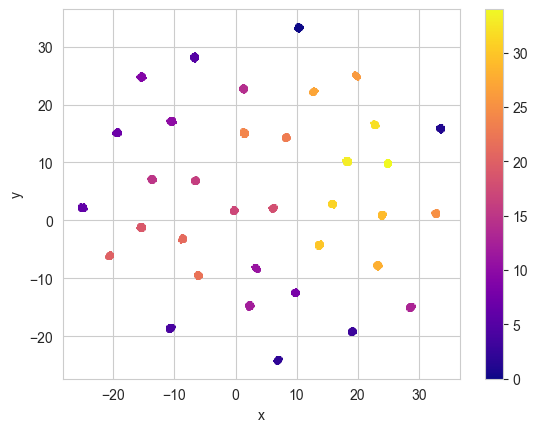

In [11]:
dfBc['x'] = dfBc['reduced'].apply(lambda x: x[0])
dfBc['y'] = dfBc['reduced'].apply(lambda x: x[1])
dfBc.plot.scatter(x='x', y='y', c=dfBc['umap'], cmap="plasma", marker='+')

In [12]:
dfBc.head()

,nodeId,propertyValue,raw,reduced,umap,x,y
0,10000,"[0.07198158, -0.07198158, 0.0, -0.14396316, -0...",32,"[-13.690143, 7.144661]",15,-13.690143,7.144661
1,10001,"[0.13703774, -0.06851887, 0.0, -0.13703774, -0...",33,"[-20.630442, -6.1759024]",20,-20.630442,-6.175902
2,10002,"[0.145865, -0.0729325, 0.0, -0.0729325, -0.072...",28,"[7.1399574, -24.018505]",2,7.139957,-24.018505
3,10003,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.16064386, -0.08032...",7,"[12.783169, 22.270233]",27,12.783169,22.270233
4,10004,"[0.07738232, 0.0, 0.0, 0.0, 0.0, 0.15476464, -...",17,"[32.77997, 1.0982771]",25,32.779968,1.098277


## Approach B - Layered

### Project

In [13]:
PROJECTION2 = 'ABZ2'
list(map(lambda x: gds.graph.drop(gds.graph.get(x)), list(filter(lambda x: x in [PROJECTION2], gds.graph.list()['graphName']))))
cypher = """
CALL {
    MATCH (a:A)-[r1:FOLLOW]->(b:B)
    RETURN a AS source, labels(a) AS sourceLabel, b AS target, labels(b) AS targetLabel, type(r1) AS relType
    UNION ALL
    MATCH (a:A)-[r1:FOLLOW]->(b:B)-[r2:TRAIT]->(z:Z)
    RETURN b AS source, labels(b) AS sourceLabel, z AS target, labels(z) AS targetLabel, type(r2) AS relType
}
RETURN gds.graph.project($projection_name, source, target,
  {sourceNodeLabels: sourceLabel,
  targetNodeLabels: targetLabel,
  relationshipType: relType},
  {undirectedRelationshipTypes: ['*']})
"""

GB, result = gds.graph.cypher.project(cypher, projection_name=PROJECTION2)
result
gds.graph.list()

,degreeDistribution,graphName,database,databaseLocation,memoryUsage,sizeInBytes,nodeCount,relationshipCount,configuration,density,creationTime,modificationTime,schema,schemaWithOrientation
0,"{'min': 1, 'max': 5784, 'p90': 5, 'p999': 5, '...",ABZ,neo4j,local,None,-1,20007,100000,"{'readConcurrency': 4, 'undirectedRelationship...",0.00025,2024-09-06T10:25:39.347778000+00:00,2024-09-06T10:25:39.478976000+00:00,"{'graphProperties': {}, 'nodes': {'A': {}, 'B'...","{'graphProperties': {}, 'nodes': {'A': {}, 'B'..."
1,"{'min': 1, 'max': 5784, 'p90': 5, 'p999': 5, '...",ABZ2,neo4j,local,8831 KiB,9043694,20007,100000,"{'readConcurrency': 4, 'undirectedRelationship...",0.00025,2024-09-06T10:26:04.165883000+00:00,2024-09-06T10:26:04.205445000+00:00,"{'graphProperties': {}, 'nodes': {'A': {}, 'B'...","{'graphProperties': {}, 'nodes': {'A': {}, 'B'..."


### Embed B to Z

In [14]:
EMBEDDING2 = 'fastRP2'
GB = gds.graph.get(PROJECTION2)
gds.fastRP.mutate(GB, iterationWeights=[1.0], embeddingDimension=EMBEDDING_DIMENSION, mutateProperty=EMBEDDING2, nodeLabels=['B', 'Z'], randomSeed=RANDOM_SEED, concurrency=1)
dfB2 = gds.graph.nodeProperty.stream(GB, EMBEDDING2, 'B')
dfB2['labels'] = dfB2.apply(lambda x: ['B'], axis='columns')
dfB2.head()

,nodeId,propertyValue,labels
0,10000,"[0.07198158, -0.07198158, 0.0, -0.14396316, -0...",[B]
1,10001,"[0.13703774, -0.06851887, 0.0, -0.13703774, -0...",[B]
2,10002,"[0.145865, -0.0729325, 0.0, -0.0729325, -0.072...",[B]
3,10003,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.16064386, -0.08032...",[B]
4,10004,"[0.07738232, 0.0, 0.0, 0.0, 0.0, 0.15476464, -...",[B]


### Stream A nodes

Add zero vectors

In [15]:
gds.wcc.mutate(GB, mutateProperty='wcc')
dfA1 = gds.graph.nodeProperty.stream(GB, 'wcc', 'A')
dfA1['propertyValue'] = dfA1.apply(lambda x: list(map(lambda x: 0.0, range(int(EMBEDDING_DIMENSION)))), axis='columns')
dfA1['labels'] = dfA1.apply(lambda x: ['A'], axis='columns')
dfA1.head()

,nodeId,propertyValue,labels
0,0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",[A]
1,1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",[A]
2,2,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",[A]
3,3,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",[A]
4,4,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",[A]


### Stream FOLLOW relationships

In [16]:
relationships = gds.graph.relationships.stream(GB, ['FOLLOW'])
relationships.head()

,sourceNodeId,targetNodeId,relationshipType
0,0,10000,FOLLOW
1,10000,0,FOLLOW
2,1,10001,FOLLOW
3,10001,1,FOLLOW
4,2,10002,FOLLOW


### Construct Graph

In [17]:
NODE_SELF_INFLUENCE = 0.0
PROJECTION3 = 'ABZ3'
list(map(lambda x: gds.graph.drop(gds.graph.get(x)), list(filter(lambda x: x in [PROJECTION3], gds.graph.list()['graphName']))))
GC = gds.graph.construct(PROJECTION3, pd.concat([dfB2, dfA1]), relationships)
gds.graph.list()

Uploading Nodes:   0%|          | 0/20000 [00:00<?, ?Records/s]

Uploading Relationships:   0%|          | 0/20000 [00:00<?, ?Records/s]

/Users/olgarazvenskaia/.env/fastrp-repr/lib/python3.11/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'TopologyDataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'TopologyDataFrame.transpose' instead.
  return bound(*args, **kwds)


,degreeDistribution,graphName,database,databaseLocation,memoryUsage,sizeInBytes,nodeCount,relationshipCount,configuration,density,creationTime,modificationTime,schema,schemaWithOrientation
0,"{'min': 1, 'max': 1, 'p90': 1, 'p999': 1, 'p99...",ABZ3,neo4j,none,26 MiB,27752676,20000,20000,"{'readConcurrency': 4, 'jobId': '680ae403-98c0...",0.00005,2024-09-06T10:26:04.857622000+00:00,2024-09-06T10:26:04.857607000+00:00,"{'graphProperties': {}, 'nodes': {'A': {'prope...","{'graphProperties': {}, 'nodes': {'A': {'prope..."
1,"{'min': 1, 'max': 5784, 'p90': 5, 'p999': 5, '...",ABZ,neo4j,local,None,-1,20007,100000,"{'readConcurrency': 4, 'undirectedRelationship...",0.00025,2024-09-06T10:25:39.347778000+00:00,2024-09-06T10:25:39.478976000+00:00,"{'graphProperties': {}, 'nodes': {'A': {}, 'B'...","{'graphProperties': {}, 'nodes': {'A': {}, 'B'..."
2,"{'min': 1, 'max': 5784, 'p90': 5, 'p999': 5, '...",ABZ2,neo4j,local,None,-1,20007,100000,"{'readConcurrency': 4, 'undirectedRelationship...",0.00025,2024-09-06T10:26:04.165883000+00:00,2024-09-06T10:26:04.373690000+00:00,"{'graphProperties': {}, 'nodes': {'A': {'wcc':...","{'graphProperties': {}, 'nodes': {'A': {'wcc':..."


### Embed combining graph & previously calculated embeddings

In [18]:
EMBEDDING3 = 'fastRP3'
PROPERTY_RATIO = 0.5
gds.fastRP.mutate(GC,
                  embeddingDimension=EMBEDDING_DIMENSION, iterationWeights=[1.0], mutateProperty=EMBEDDING3,
                  nodeSelfInfluence=NODE_SELF_INFLUENCE, propertyRatio=PROPERTY_RATIO, featureProperties=['propertyValue'], concurrency=1)

nodePropertiesWritten                                                20000
mutateMillis                                                             0
nodeCount                                                            20000
preProcessingMillis                                                      0
computeMillis                                                           90
configuration            {'mutateProperty': 'fastRP3', 'jobId': '0ab17d...
Name: 0, dtype: object

In [19]:
EMBEDDING3_09 = 'fastRP3_09'
PROPERTY_RATIO_09 = 0.9
gds.fastRP.mutate(GC,
                  embeddingDimension=EMBEDDING_DIMENSION, iterationWeights=[1.0], mutateProperty=EMBEDDING3_09,
                  nodeSelfInfluence=NODE_SELF_INFLUENCE, propertyRatio=PROPERTY_RATIO_09, featureProperties=['propertyValue'], concurrency=1)


EMBEDDING3_01 = 'fastRP3_01'
PROPERTY_RATIO_01 = 0.1
gds.fastRP.mutate(GC,
                  embeddingDimension=EMBEDDING_DIMENSION, iterationWeights=[1.0], mutateProperty=EMBEDDING3_01,
                  nodeSelfInfluence=NODE_SELF_INFLUENCE, propertyRatio=PROPERTY_RATIO_01, featureProperties=['propertyValue'], concurrency=1)

nodePropertiesWritten                                                20000
mutateMillis                                                             0
nodeCount                                                            20000
preProcessingMillis                                                      0
computeMillis                                                           64
configuration            {'mutateProperty': 'fastRP3_01', 'jobId': '667...
Name: 0, dtype: object

In [20]:
def get_cluster_assignments(graphName, propertyName, nodeLabel):
    _ddf = gds.graph.nodeProperty.stream(graphName, propertyName, nodeLabel)
    _ddf2 = cluster_embedding(_ddf, HDBSCAN(min_samples=20, min_cluster_size=10, n_jobs=-1), cluster_column='raw')
    _ddf2 = reduce_embedding(_ddf2, umap.UMAP(n_neighbors=30, min_dist=0.1, n_components=2))
    _ddf2 = cluster_embedding(_ddf2, HDBSCAN(min_samples=20, min_cluster_size=10, n_jobs=-1), property_column='reduced', cluster_column='umap')
    
    _ddf2['x'] = _ddf2['reduced'].apply(lambda x: x[0])
    _ddf2['y'] = _ddf2['reduced'].apply(lambda x: x[1])
    _ddf2.plot.scatter(x='x', y='y', c=_ddf2['umap'], cmap="plasma", marker='+', title=propertyName+' '+nodeLabel)
    
    return _ddf2['umap']

0       25
1       29
2       23
3        5
4        2
        ..
9995    32
9996    17
9997     8
9998    31
9999    13
Name: umap, Length: 10000, dtype: int64
0       16
1       31
2       34
3       22
4       19
        ..
9995    25
9996    20
9997     9
9998    32
9999     3
Name: umap, Length: 10000, dtype: int64
0        8
1       13
2       18
3       17
4       19
        ..
9995     9
9996    29
9997    12
9998    26
9999     8
Name: umap, Length: 10000, dtype: int64
0        8
1       31
2        4
3       26
4        1
        ..
9995    22
9996     0
9997    23
9998     7
9999    14
Name: umap, Length: 10000, dtype: int64


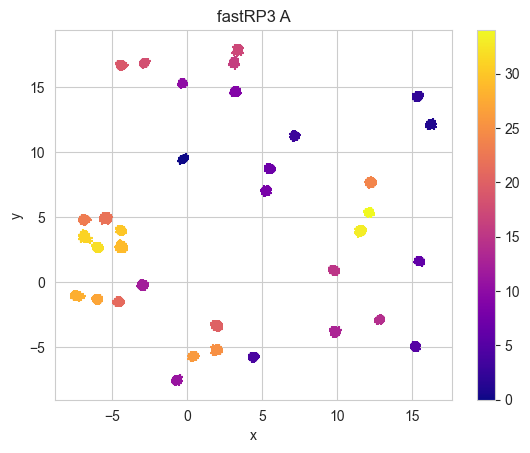

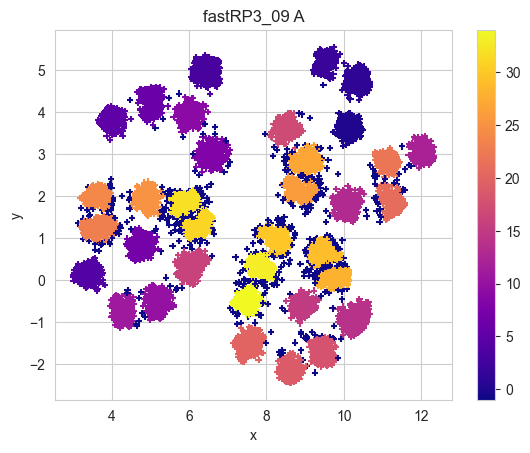

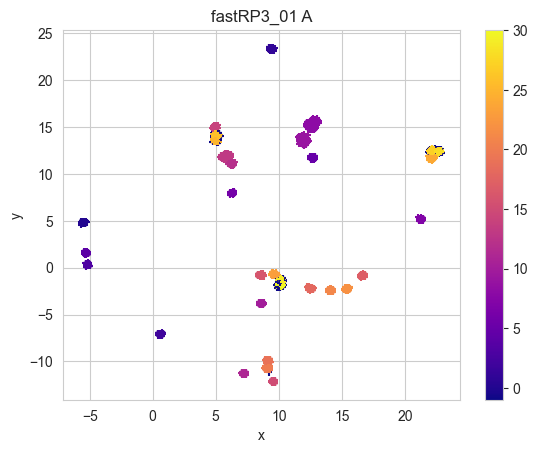

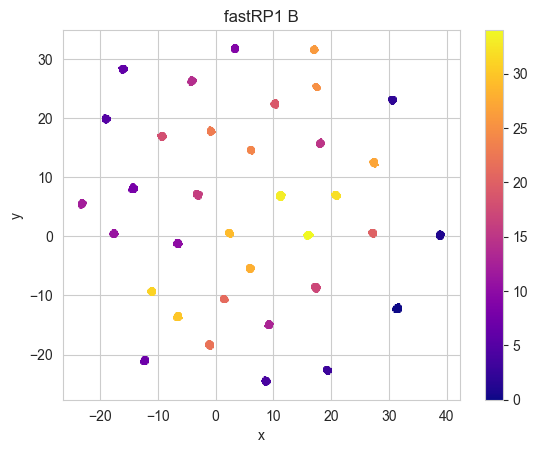

In [21]:
labels_05 = get_cluster_assignments(GC, EMBEDDING3, 'A')
print(labels_05)
labels_09 = get_cluster_assignments(GC, EMBEDDING3_09, 'A')
print(labels_09)
labels_01 = get_cluster_assignments(GC, EMBEDDING3_01, 'A')
print(labels_01)
labels_B = get_cluster_assignments(GA, EMBEDDING1, 'B')
print(labels_B)

### Stream A Embedding

In [22]:
dfA2 = gds.graph.nodeProperty.stream(GC, EMBEDDING3, 'A')
dfA2.head()
dfA2.describe()

,nodeId
count,10000.00000
mean,4999.50000
std,2886.89568
min,0.00000
25%,2499.75000
50%,4999.50000
75%,7499.25000
max,9999.00000


### Cluster, reduce, cluster

In [23]:
%%time
dfAc = cluster_embedding(dfA2, HDBSCAN(min_samples=20, min_cluster_size=10, n_jobs=-1), cluster_column='raw')
print("1")
print(dfAc)
dfAc = reduce_embedding(dfAc, umap.UMAP(n_neighbors=30, min_dist=0.1, n_components=2))
print("2")
print(dfAc)
dfAc = cluster_embedding(dfAc, HDBSCAN(min_samples=20, min_cluster_size=10, n_jobs=-1), property_column='reduced', cluster_column='umap')
print("3")
print(dfAc)

1
      nodeId                                      propertyValue  raw
0          0  [0.15392405, -0.15392405, 0.0, 0.15392405, -0....   -1
1          1  [0.0, 0.16291736, 0.0, 0.0, 0.0, 0.16291736, 0...   -1
2          2  [0.0, 0.0, 0.0, 0.0, 0.14981681, 0.14981681, -...   -1
3          3  [0.0, 0.0, 0.0, -0.17333369, 0.17333369, 0.173...   -1
4          4  [0.0, 0.0, 0.0, -0.15277539, 0.0, -0.15277539,...   -1
...      ...                                                ...  ...
9995    9995  [0.15038614, 0.0, -0.15038614, 0.0, 0.0, 0.0, ...    4
9996    9996  [-0.16556457, 0.0, 0.0, 0.0, 0.0, 0.0, 0.16556...    4
9997    9997  [0.0, 0.17890772, 0.0, 0.0, -0.17890772, 0.0, ...   -1
9998    9998  [0.0, 0.0, 0.0, 0.0, -0.16754755, 0.0, 0.0, -0...   -1
9999    9999  [0.16084208, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...   -1

[10000 rows x 3 columns]
2
      nodeId                                      propertyValue  raw  \
0          0  [0.15392405, -0.15392405, 0.0, 0.15392405, -0....   -1  

### Raw Clusters

In [24]:
dfAc['raw'].value_counts()

raw
-1    9234
 4     691
 5      19
 1      19
 0      14
 3      12
 2      11
Name: count, dtype: int64

### UMAP Clusters

In [25]:
dfAc['umap'].value_counts()

umap
11    318
18    317
25    312
8     306
33    302
22    301
32    298
20    297
17    296
14    295
28    293
4     293
6     292
1     289
0     286
2     286
5     285
27    284
24    283
26    282
7     282
16    281
13    280
29    280
3     279
19    277
12    275
23    274
15    271
31    271
30    270
10    268
34    264
21    264
9     249
Name: count, dtype: int64

<Axes: xlabel='x', ylabel='y'>

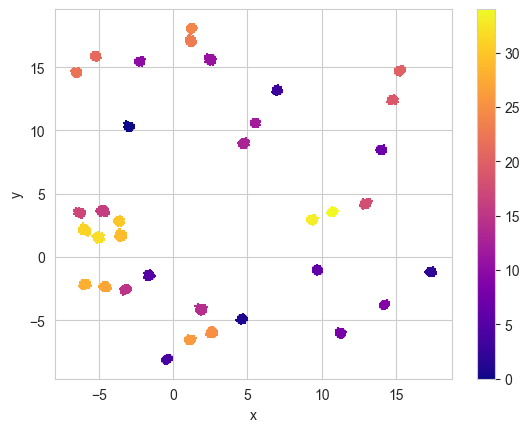

In [26]:
dfAc['x'] = dfAc['reduced'].apply(lambda x: x[0])
dfAc['y'] = dfAc['reduced'].apply(lambda x: x[1])
dfAc.plot.scatter(x='x', y='y', c=dfAc['umap'], cmap="plasma", marker='+')

In [27]:
relmap = dict(map(lambda x: (x['sourceNodeId'], x['targetNodeId']), relationships.to_dict(orient='records')))
dfAc['FOLLOW'] = dfAc.apply(lambda x: relmap[x['nodeId']], axis=1)
dfAc.head()

,nodeId,propertyValue,raw,reduced,umap,x,y,FOLLOW
0,0,"[0.15392405, -0.15392405, 0.0, 0.15392405, -0....",-1,"[2.7606714, -5.80422]",25,2.760671,-5.804220,10000
1,1,"[0.0, 0.16291736, 0.0, 0.0, 0.0, 0.16291736, 0...",-1,"[-3.5771363, 1.737071]",29,-3.577136,1.737071,10001
2,2,"[0.0, 0.0, 0.0, 0.0, 0.14981681, 0.14981681, -...",-1,"[-6.204152, 3.4913225]",17,-6.204152,3.491323,10002
3,3,"[0.0, 0.0, 0.0, -0.17333369, 0.17333369, 0.173...",-1,"[17.301922, -1.1800874]",2,17.301922,-1.180087,10003
4,4,"[0.0, 0.0, 0.0, -0.15277539, 0.0, -0.15277539,...",-1,"[15.259124, 14.704087]",20,15.259124,14.704087,10004


## Compare - Ovelap between clusters

The cluster membership of B nodes (B->Z embedding) should overlap with the cluster membership of the A node (A->B property embedding).

Maximal overlap is when the heatmap below has a red diagonal.

This is observed when propertyRatio = 0.5 (or exactly 1.0). Deviation from 0.5 toward 0.0 or 1.0 results in an embedding that carries little information from the original property embeddings (the cluster ovelap breaks down).

       11     18     25     8      33     22     32     20     17     14  ...  \
28  100.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0  ...   
33    0.0  100.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0  ...   
15    0.0    0.0  100.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0  ...   
5     0.0    0.0    0.0  100.0    0.0    0.0    0.0    0.0    0.0    0.0  ...   
14    0.0    0.0    0.0    0.0  100.0    0.0    0.0    0.0    0.0    0.0  ...   
30    0.0    0.0    0.0    0.0    0.0  100.0    0.0    0.0    0.0    0.0  ...   
12    0.0    0.0    0.0    0.0    0.0    0.0  100.0    0.0    0.0    0.0  ...   
25    0.0    0.0    0.0    0.0    0.0    0.0    0.0  100.0    0.0    0.0  ...   
2     0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0  100.0    0.0  ...   
10    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0  100.0  ...   
19    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0  ...   
16    0.0    0.0    0.0    0

<Axes: >

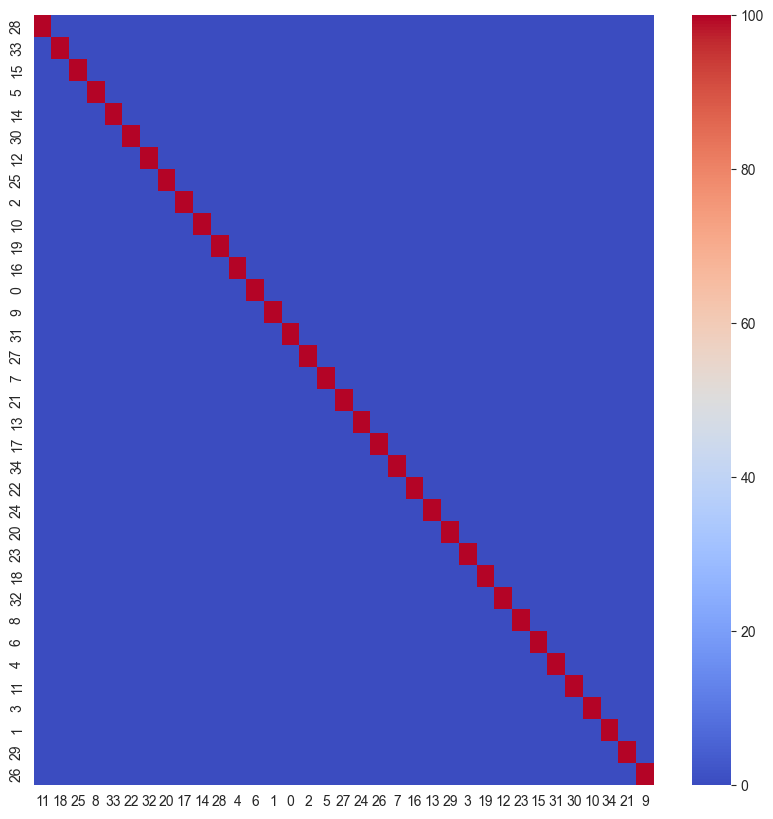

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt

I = {}
for x in dfAc['umap'].value_counts().index:
  I[x] = {}
  for y in dfBc['umap'].value_counts().index:
    sA = set(dfAc[dfAc['umap'] == x]['FOLLOW'])
    sB = set(dfBc[dfBc['umap'] == y]['nodeId'])
    I[x][y] = 100 * len(sA & sB) / len(sA | sB)

print(pd.DataFrame(I))
fig, ax = plt.subplots(figsize=(10, 10))
#sns.heatmap(pd.DataFrame(I), cmap='coolwarm', annot=True, fmt=".0f")
sns.heatmap(pd.DataFrame(I), cmap='coolwarm')

In [29]:
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score, fowlkes_mallows_score, homogeneity_completeness_v_measure

# Example cluster assignments from two algorithms
labels_algorithm_1 = dfAc['umap']
labels_algorithm_2 = dfBc['umap']

# Adjusted Rand Index
ari = adjusted_rand_score(labels_algorithm_1, labels_algorithm_2)
print(f"Adjusted Rand Index (ARI): {ari:.3f}")

# Normalized Mutual Information
nmi = normalized_mutual_info_score(labels_algorithm_1, labels_algorithm_2)
print(f"Normalized Mutual Information (NMI): {nmi:.3f}")

# Fowlkes-Mallows Index
fmi = fowlkes_mallows_score(labels_algorithm_1, labels_algorithm_2)
print(f"Fowlkes-Mallows Index (FMI): {fmi:.3f}")

# Homogeneity, Completeness, and V-Measure
homogeneity, completeness, v_measure = homogeneity_completeness_v_measure(labels_algorithm_1, labels_algorithm_2)
print(f"Homogeneity: {homogeneity:.3f}")
print(f"Completeness: {completeness:.3f}")
print(f"V-Measure: {v_measure:.3f}")


Adjusted Rand Index (ARI): 1.000
Normalized Mutual Information (NMI): 1.000
Fowlkes-Mallows Index (FMI): 1.000
Homogeneity: 1.000
Completeness: 1.000
V-Measure: 1.000


## Close

In [30]:
#gds.graph.drop(G)
#gds.close()
#n4j.close()
#driver.close()